## Implement VAE (Variational Autoencoder) with tensorflow distributions

In [1]:
import tensorflow as tf
import tensorflow.contrib.distributions as tfd

import numpy as np
import input_data
import matplotlib.pyplot as plt
import os
from scipy.misc import imsave as ims

from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets

/Users/lifa08/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def safe_mkdir(path):
    """ Create a directory if there isn't one already. """
    try:
        os.mkdir(path)
    except OSError:
        pass

In [3]:
def sigmoid(x):
    if x.ndim == 1:
        return math.exp(-np.logaddexp(0, -x))

    return np.reshape(np.exp(-np.logaddexp(0, -x.flatten())), x.shape)

In [4]:
class VAE:
    def __init__(self, dataset, gen_num_hidden, recog_num_hidden, 
                 num_z, dim_input, learning_rate=0.001, batch_size=100, skip_step=500):
        '''Initiate the VAE model.
        dataset: data used to train the model
        gen_num_hidden: the number of units in hidden layer of the generation network
        rec_num_hidden: the number of units in the hidden layer of the recognition network
        num_z: the number of latent variables
        dim_input: the dimention of input data
        '''
        self.gen_num_hidden = gen_num_hidden
        self.recog_num_hidden = recog_num_hidden
        self.num_z = num_z
        self.lr = learning_rate
        self.batch_size = batch_size

        self.skip_step = skip_step
        self.dataset = dataset
        self.dim_input = dim_input

        self.x = tf.placeholder(tf.float32, [None, dim_input])

        self.global_step = tf.get_variable('global_step',
                                           initializer=tf.constant(0),
                                           trainable=False)

        self.prior = tfd.MultivariateNormalDiag(tf.zeros([num_z]),
                                                tf.ones([num_z]))

        self._build_graph()

        init = tf.global_variables_initializer()
        self.sess = tf.InteractiveSession()
        self.sess.run(init)

    def _create_recognition(self):
        ''' Recognition network which maps inputs
            onto a normal distribution in latent space.
        '''
        with tf.variable_scope("recognition"):
            recog_hidden_1 = tf.layers.dense(self.x,
                                           self.recog_num_hidden,
                                           tf.nn.relu)
            recog_hidden_2 = tf.layers.dense(recog_hidden_1,
                                            self.recog_num_hidden,
                                            tf.nn.relu)

            self.z_mean = tf.layers.dense(recog_hidden_2,
                                          self.num_z)

            self.z_sigma = tf.layers.dense(recog_hidden_2,
                                           self.num_z,
                                           tf.nn.softplus)
 
            self.posterior = tfd.MultivariateNormalDiag(self.z_mean, self.z_sigma)

    def _create_generation(self, z):
        ''' Generation network which use samples of 
            latent space to generate observed variables x.
            z: sample from latent space
        '''
        with tf.variable_scope("generation"):
            gen_hidden_1 = tf.layers.dense(z,
                                         self.gen_num_hidden,
                                         tf.nn.relu)
            gen_hidden_2 = tf.layers.dense(gen_hidden_1,
                                          self.gen_num_hidden,
                                          tf.nn.relu)

            self.logits = tf.layers.dense(gen_hidden_2,
                                         self.dim_input)

            return tfd.Independent(tfd.Bernoulli(self.logits), 2)

    def _create_loss(self):
        '''Calculate the loss.'''
        with tf.name_scope('loss'):
            likelihood = self.x_dist.log_prob(self.x)
            kl_divergence = tfd.kl_divergence(self.posterior, self.prior)
            elbo = tf.reduce_mean(likelihood - kl_divergence)
            self.loss = -elbo

    def _create_optimizer(self):
        self.optimizer = tf.train.AdamOptimizer(self.lr).minimize(
                                                                self.loss,
                                                                global_step=self.global_step)

    def _create_summaries(self):
        with tf.name_scope('summaries'):
            tf.summary.scalar('loss', self.loss)
            tf.summary.histogram('histogram_loss', self.loss)
            self.summary_op = tf.summary.merge_all()

    def _build_graph(self):
        '''Define the whole VAE network.'''
        self._create_recognition_run = tf.make_template(name_="recognition",
                                                       func_=self._create_recognition)
        self._create_generation_run = tf.make_template(name_="generation",
                                                      func_=self._create_generation)
        self._create_recognition_run()
        self.x_dist = self._create_generation_run(self.posterior.sample())

        self._create_loss()
        self._create_optimizer()
        self._create_summaries()

    def train(self, num_train_steps, num_samples, ckpt_dir):
        ''' Train the VAE network
        '''
        saver = tf.train.Saver()

        safe_mkdir(ckpt_dir)

        # if that checkpoint exists, restore from checkporint
        ckpt = tf.train.get_checkpoint_state(os.path.dirname(
                                            os.path.join(ckpt_dir, "checkpoint")))
        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(self.sess, ckpt.model_checkpoint_path)
            print('restoing from checkpoint')

        writer = tf.summary.FileWriter('graphs/vae/lr' + str(self.lr), self.sess.graph)
        initial_step = self.global_step.eval()

        avg_cost = 0.
        total_batch = int(n_samples / self.batch_size)

        # Loop over all batches
        for index in range(initial_step, initial_step + num_train_steps):
            batch_xs, _ = self.dataset.next_batch(self.batch_size) # mnist = self.dataset?

            loss, _, summaries= self.sess.run([self.loss,
                                               self.optimizer,
                                               self.summary_op],
                                              feed_dict={self.x: batch_xs})

            writer.add_summary(summaries, global_step=index)

            # Compute average loss
            avg_cost += loss / num_samples * self.batch_size

            # Display logs per epoch step
            if (index + 1) % self.skip_step == 0:
                print("Epoch:", '%04d' % (index + 1), 
                      "loss=", "{:.9f}".format(avg_cost))

                avg_cost = 0.
                saver.save(self.sess,
                           os.path.join(ckpt_dir, "vae-model"),
                           global_step=index)

        writer.close()

    def transform(self, X):
        '''Map observed data x into latent space'''
        return self.sess.run(self.z_mean, feed_dict={self.x: X})

    def reconstruct(self, X):
        """Reconstruct given observed data. """
        logits = self.sess.run(self.logits, feed_dict={self.x: X})
        return sigmoid(logits)

    def generate_from_sample(self, z_mu=None, batch_size=1):
        '''Generate observed data X by sampling the distribution of latent space.'''
        if z_mu is None:
            z_sample = self.prior.sample(batch_size)
        else:
            z_dist = tfd.MultivariateNormalDiag(z_mu, tf.ones_like(z_mu))                                 
            z_sample = z_dist.sample(batch_size)

        # Since the VAE._create_generattion network returns Bernoulli distribution,
        # we use its mean, namely its probability, to represent generated x.
        assert 28 * 28 == self.dim_input
        x_generated = tf.reshape(self._create_generation_run(z_sample).mean(),
                                     [-1, 28, 28])
        return self.sess.run(x_generated)

    def generate_from_z_mu(self, z_mu=None):
        '''Generate observed data X with the specified mean of the distribution of latent space.'''
        if z_mu is None:
            z_mu = tf.zeros([1, self.num_z])
        else:
            z_mu = tf.convert_to_tensor(z_mu, dtype=tf.float32)

        assert 28 * 28 == self.dim_input
        x_generated = tf.reshape(self._create_generation_run(z_mu).mean(),
                                     [-1, 28, 28])
        return self.sess.run(x_generated)

## Train VAE model with mnist dataset

In [5]:
# download mnist dataset
mnist = read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples
dim_input = mnist.test.images.shape[1]

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [6]:
tf.reset_default_graph()

gen_num_hidden = 500
recog_num_hidden = 500
num_z = 2

vae_model = VAE(mnist.train, gen_num_hidden, recog_num_hidden, num_z, dim_input)

In [7]:
num_train_steps = 500
vae_model.train(num_train_steps, n_samples, "vae_2d_prob")

INFO:tensorflow:Restoring parameters from vae_2d_prob/vae-model-47999
restoing from checkpoint
Epoch: 48500 loss= 11200.596780895


## Check the effectiveness of the trained model

We can see from the image, the model can seperate latent space accordong to the visible observed data well. But digit 9 is not that differentiable from digit 4.

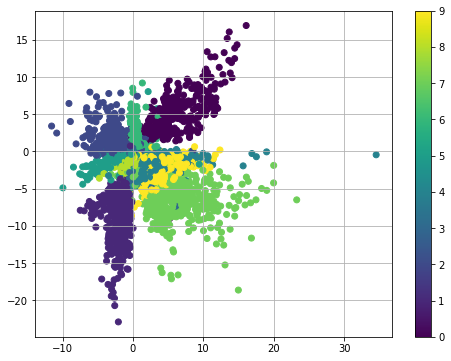

In [8]:
x_sample, y_sample = mnist.test.next_batch(5000)
z_mu = vae_model.transform(x_sample)
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=np.argmax(y_sample, 1))
plt.colorbar()
plt.grid()

## Check how well the trained model can reconstruct test sample

In [9]:
x_sample = mnist.test.next_batch(5)[0]
x_reconstruct = vae_model.reconstruct(x_sample)

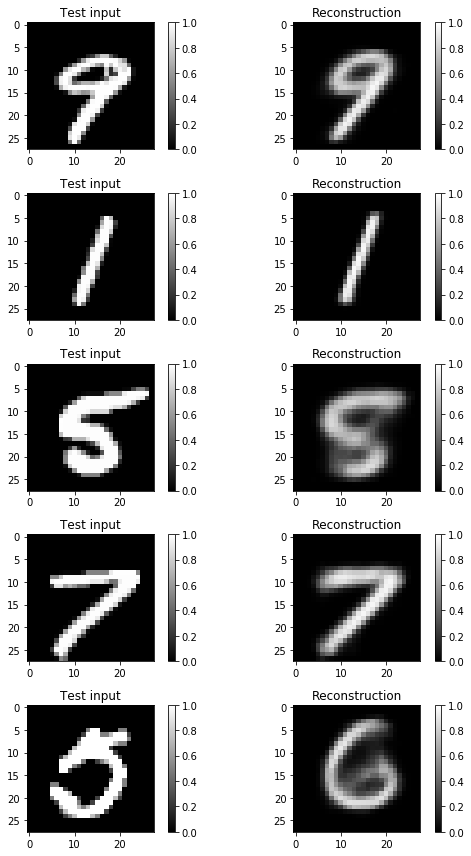

In [10]:
plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

## Use the trained model to generate observed data

In [13]:
def plot_samples(ax, samples):
    for index, sample in enumerate(samples):
        ax[index].imshow(sample, cmap='gray')
        ax[index].axis('off')

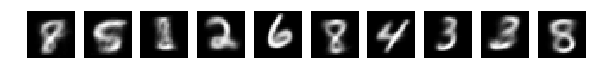

In [15]:
num_x = 10
generated_xs = vae_model.generate_from_sample(batch_size=num_x)
fig, ax = plt.subplots(nrows=1, ncols=num_x, figsize=(10, 20))
plot_samples(ax[0:], generated_xs)

## Use the generator network to plot reconstrunctions at the positions in the latent space for which they have been generated.

In [16]:
def plot_generated_x_canvas(num, z_mu_range, figsize=(9, 9), from_sample=False):
    '''Generated observed data x and plot it on canvas'''
    if from_sample:
        gen_func = vae_model.generate_from_sample
    else:
        gen_func = vae_model.generate_from_z_mu

    x_values = np.linspace(z_mu_range[0], z_mu_range[1], num, dtype=np.float32)
    y_values = np.linspace(z_mu_range[0], z_mu_range[1], num, dtype=np.float32)

    # np.empty: return a new array of given shape and type, without initializing entries.
    canvas = np.empty((28*num, 28*num))

    for i, yi in enumerate(x_values):
        for j, xi in enumerate(y_values):
            z_mu = np.array([[xi, yi]])
            x_mean = gen_func(z_mu)
            canvas[(num - i - 1) * 28: (num - i) * 28, j * 28: (j + 1) * 28] = x_mean

    plt.figure(figsize=figsize)

    plt.imshow(canvas, origin="upper", cmap="gray")

    xlocs, xlabels = plt.xticks()
    new_xlabels = np.round(np.linspace(z_mu_range[0], z_mu_range[1], len(xlocs)),
                           decimals=1)
    plt.xticks(xlocs[1:-1], new_xlabels[1:-1])

    ylocs, ylabels = plt.yticks()
    new_ylabels = np.round(np.linspace(z_mu_range[1], z_mu_range[0], len(ylocs)),
                           decimals=1)
    plt.yticks(ylocs[1:-1], new_ylabels[1:-1])

    plt.tight_layout()

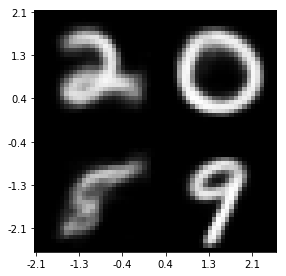

In [17]:
plot_generated_x_canvas(2, [-3, 3], (4, 4), from_sample=True)

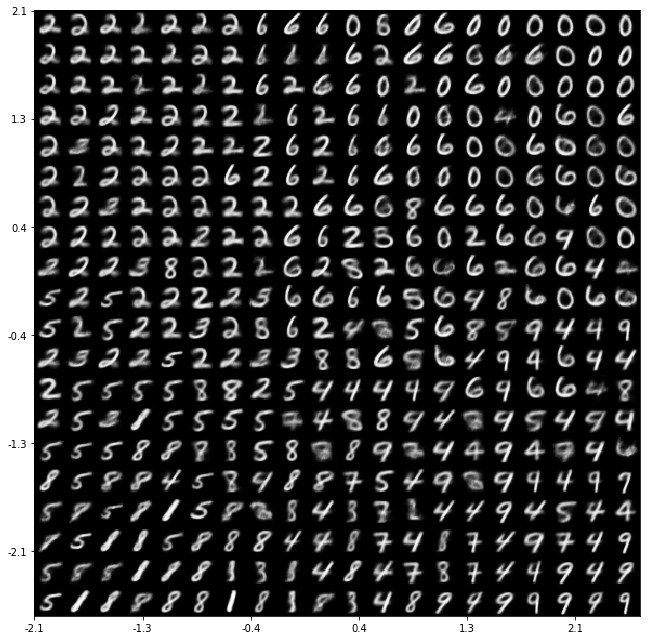

In [18]:
plot_generated_x_canvas(20, [-3.0, 3.0], from_sample=True)

## Generate from the mean of the posterior distribution of latent space
Assume that we know the distribution mean of latent space, we use this mean to generate data X. This is the approximation of the optimal situation where the mean is calculated from a huge number of samples from the posterier distribution.

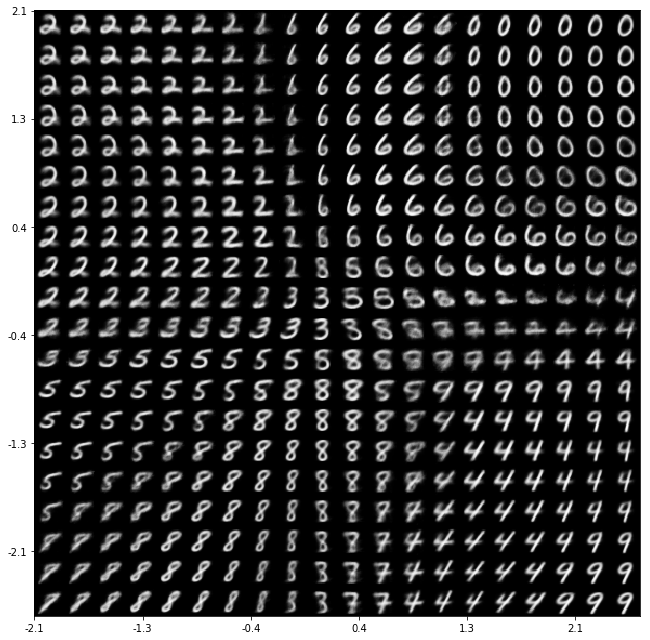

In [19]:
plot_generated_x_canvas(20, [-3.0, 3.0])

(1, 28, 28)


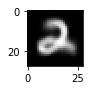

In [20]:
x_generated = vae_model.generate_from_z_mu([[-2.8, 2.9]])
print(x_generated.shape)
plt.figure(figsize=(1, 2))
plt.imshow(x_generated[0], origin="upper", cmap="gray")

(1, 28, 28)


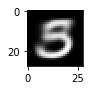

In [21]:
x_generated = vae_model.generate_from_z_mu()
print(x_generated.shape)
plt.figure(figsize=(1, 2))
plt.imshow(x_generated[0], origin="upper", cmap="gray")